# ✨ Descripción General del Sistema ✨

Este sistema está diseñado para **procesar**, **analizar** y **visualizar datos** relacionados con incidentes delictivos en diferentes distritos, complementando esta información con estadísticas socioeconómicas. A través de un flujo organizado, se busca descubrir patrones y generar insights valiosos de manera eficiente.

## 🎯 **Objetivos del Sistema**

1. 🛠️ **Preprocesamiento de Datos**:
   - ✅ Limpieza y normalización de datos, eliminando inconsistencias como tildes y caracteres no deseados.
   - ✅ Estandarización de formatos para facilitar comparaciones entre múltiples conjuntos de datos.
   - ✅ Conversión de columnas, como fechas y horas, para asegurar su correcto manejo.

2. 📊 **Análisis de Datos**:
   - 🔍 Identificar patrones, correlaciones y tendencias en los datos.
   - 🗺️ Filtrar y agrupar información por categorías clave (distritos, horas, tipos de delitos, etc.).

3. 🎨 **Visualización de Resultados**:
   - 📉 Creación de gráficos claros y dinámicos para representar los resultados.
   - 🌡️ Generación de mapas de calor, gráficos de barras y otras visualizaciones atractivas.
   - 📅 Análisis temporal (días de la semana, horas críticas, etc.).

## 🏗️ **Estructura del Sistema**

### 1️⃣ **Preprocesamiento de Datos**
- 🧹 **Limpieza**: Eliminación de inconsistencias como tildes, espacios extra y caracteres especiales.
- 🔄 **Transformación**: Conversión de cadenas a fechas, horas, y otros formatos requeridos.
- ➕ **Enriquecimiento**: Generación de nuevas columnas derivadas, como días de la semana y rangos horarios.

### 2️⃣ **Visualización de los Datos**
- 📊 **Gráficos por Categoría**:
  - Análisis de delitos por tipo, sexo, y hora del día.
  - Relación entre factores socioeconómicos y la cantidad de delitos.
- 🌡️ **Mapas de Calor**:
  - Representación de delitos por hora y tipo, destacando patrones críticos.
- 🏆 **Insights Visuales**:
  - Explorar cómo factores como la tasa de ocupación influyen en la cantidad de delitos.

---

⚡ **Beneficios del Sistema**:
- 📈 **Escalabilidad**: Puede manejar grandes conjuntos de datos.
- 🛠️ **Flexibilidad**: Adaptable a diferentes estructuras y fuentes de datos.
- 💡 **Insights Accionables**: Facilita la toma de decisiones informadas basadas en datos reales.

✨ ¡Transforma datos en conocimiento con este sistema! ✨


## Preprocesamiento de datos 

### Conexion Base de Datos Postgres

In [24]:
import psycopg
import os

# ================================================
# Definición de parámetros de conexión
# ================================================
# Descripción general:
# Este bloque define los parámetros necesarios para conectarse a una base de datos PostgreSQL.
# Los parámetros incluyen:
# - `dbname`: Nombre de la base de datos a la que se conectará.
# - `user`: Usuario de la base de datos.
# - `password`: Contraseña para autenticar al usuario.
# - `host`: Dirección del host donde se encuentra la base de datos.
# - `port`: Puerto en el que escucha la base de datos.

conn_params = {
    'dbname': 'datos',        # Nombre de la base de datos
    'user': 'postgres',       # Usuario de la base de datos
    'password': '12345',      # Contraseña del usuario
    'host': 'localhost',      # Dirección del servidor (localhost en este caso)
    'port': '5432'            # Puerto por defecto de PostgreSQL
}

# ================================================
# Establecer conexión con la base de datos
# ================================================
# Descripción general:
# Este bloque intenta establecer una conexión con la base de datos PostgreSQL
# utilizando los parámetros definidos anteriormente.
# En caso de éxito, imprime un mensaje de confirmación.
# Si ocurre un error, este se captura y se imprime en la consola.

try:
    # Se intenta conectar a la base de datos utilizando los parámetros
    conn = psycopg.connect(**conn_params)
    print("Conexión exitosa")
except Exception as e:
    # Captura cualquier error durante la conexión y lo imprime
    print(f"Ocurrió un error: {e}")

# ================================================
# Cierre de conexión (comentado por defecto)
# ================================================
# Descripción general:
# Es importante cerrar la conexión a la base de datos una vez que se han
# completado todas las operaciones. Este paso evita fugas de recursos.

# Descomenta la siguiente línea para cerrar la conexión cuando termines.
# conn.close()


Conexión exitosa


### 1. Función que elimine los espacios en blanco de la columna distrito para usarse en ambos conjuntos de datos.

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace

# ================================================
# Crea una sesión de Spark
# ================================================
# Descripción general:
# Este bloque crea una sesión de Spark, que es necesaria para ejecutar comandos de PySpark.
# La sesión de Spark permite procesar datos a gran escala utilizando DataFrames y RDDs.
spark = SparkSession.builder \
    .appName("Preprocessing Data") \
        .getOrCreate()

# ================================================
# Carga de datos desde archivos CSV
# ================================================
# Descripción general:
# Los datos se cargan desde dos archivos CSV: uno contiene datos del OIJ y el otro del INEC.
# Ambos DataFrames se construyen especificando encabezados y permitiendo la inferencia de tipos de datos.

# Parámetros de entrada:
# - Ruta del archivo: La ruta absoluta de los archivos CSV.
# - header=True: Especifica que los archivos CSV tienen encabezados.
# - inferSchema=True: Permite que Spark detecte automáticamente los tipos de datos.

# Descripción de la salida:
# - `oij_df` y `inec_df`: DataFrames de Spark que contienen los datos cargados.
oij_df = spark.read.csv(
    "C:\\Users\\grana\\OneDrive\\Escritorio\\Bases de datos\\spark\\data\\OIJ.csv", 
    header=True, 
    inferSchema=True
)
inec_df = spark.read.csv(
    "C:\\Users\\grana\\OneDrive\\Escritorio\\Bases de datos\\spark\\data\\inec.csv", 
    header=True, 
    inferSchema=True
)

# ================================================
# Función: eliminar_espacios_y_concatenar
# ================================================
def eliminar_espacios_y_concatenar(dataframe, columna):
    """
    Elimina los espacios en blanco y concatena las palabras en una columna específica 
    de un DataFrame de Spark.

    Parámetros:
    - dataframe (DataFrame): El DataFrame de Spark a procesar.
    - columna (str): El nombre de la columna en la que se eliminarán los espacios en blanco.

    Retorno:
    - DataFrame: Un nuevo DataFrame con los cambios aplicados a la columna especificada.

    Excepciones:
    - ValueError: Si la columna especificada no existe en el DataFrame.

    Descripción de bloques relevantes:
    - El bloque `if columna in dataframe.columns` verifica si la columna existe.
    - La función `regexp_replace` se utiliza para eliminar los espacios en blanco.
    """
    if columna in dataframe.columns:
        return dataframe.withColumn(columna, regexp_replace(dataframe[columna], " ", ""))
    else:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")

# ================================================
# Limpieza del DataFrame de OIJ
# ================================================
# Descripción general:
# Este bloque limpia la columna 'Distrito' en el DataFrame `oij_df`.
# También elimina la columna '_C11' si está presente.

try:
    # Limpia la columna 'Distrito' eliminando espacios en blanco
    oij_df = eliminar_espacios_y_concatenar(oij_df, 'Distrito')
    
    # Elimina la columna '_C11' si existe
    if '_C11' in oij_df.columns:
        oij_df = oij_df.drop('_C11')
except Exception as e:
    # Captura errores durante el procesamiento
    print(f"Error al procesar OIJ: {e}")

# ================================================
# Limpieza del DataFrame de INEC
# ================================================
# Descripción general:
# Este bloque limpia la columna 'distrito' en el DataFrame `inec_df`.

try:
    # Limpia la columna 'distrito' eliminando espacios en blanco
    inec_df = eliminar_espacios_y_concatenar(inec_df, 'distrito')
except Exception as e:
    # Captura errores durante el procesamiento
    print(f"Error al procesar INEC: {e}")

# ================================================
# Visualización de los resultados
# ================================================
# Descripción general:
# Este bloque muestra los primeros 50 registros de cada DataFrame después del preprocesamiento.

# Muestra el DataFrame de OIJ después de la limpieza
print("Datos del OIJ después de limpiar:")
oij_df.show(50, truncate=False)

# Muestra el DataFrame de INEC después de la limpieza
print("Datos del INEC después de limpiar:")
inec_df.show(50, truncate=False)


Datos del OIJ después de limpiar:
+------+-----------+----------+-------------------+--------+-----------------------------------+-------------+------+------------+----------+-------------+--------------------+
|Delito|SubDelito  |Fecha     |Hora               |Victima |SubVictima                         |Edad         |Sexo  |Nacionalidad|Provincia |Canton       |Distrito            |
+------+-----------+----------+-------------------+--------+-----------------------------------+-------------+------+------------+----------+-------------+--------------------+
|ASALTO|ARMA BLANCA|1/10/2011 |18:00:00 - 20:59:59|PERSONA |PEATON [PERSONA]                   |Mayor de edad|HOMBRE|NICARAGUA   |SAN JOSE  |ALAJUELITA   |SANFELIPE           |
|ASALTO|ARMA BLANCA|2/2/2011  |03:00:00 - 05:59:59|PERSONA |PEATON [PERSONA]                   |Mayor de edad|HOMBRE|COSTA RICA  |CARTAGO   |OREAMUNO     |SANRAFAEL           |
|ASALTO|ARMA BLANCA|10/23/2011|21:00:00 - 23:59:59|PERSONA |PEATON [PERSONA]     

### 2. Función que convierta a minúsculas el contenido de la columna distrito para usarse en ambos conjuntos de datos

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower

# ================================================
# Crear SparkSession
# ================================================
# Descripción general:
# Este bloque inicializa una SparkSession, que es el punto de entrada para usar PySpark.
# Además, se configura el paquete de conexión para PostgreSQL.

try:
    spark = SparkSession.builder \
        .appName("Proyecto SparkSQL") \
            .config("spark.jars.packages", "org.postgresql:postgresql:42.7.4") \
                .getOrCreate()
    print("SparkSession creada:", spark.version)  # Imprime la versión de Spark en uso
except Exception as e:
    # Captura y muestra errores en caso de fallos al crear la sesión
    print("Error al crear SparkSession:", str(e))

# ================================================
# Cargar CSVs
# ================================================
# Descripción general:
# Este bloque carga datos desde archivos CSV en DataFrames de Spark.
# Actualmente, este bloque está comentado para evitar errores si los archivos no están disponibles.

# df_oij = spark.read.csv("C:\\Projects\\spark\\data\\OIJ2011.csv", header=True, inferSchema=True)
# df_inec = spark.read.csv("C:\\Projects\\spark\\data\\inec.csv", header=True, inferSchema=True)

# ================================================
# Función: convertir_minusculas
# ================================================
def convertir_minusculas(df, columna):
    """
    Convierte los valores de una columna específica a minúsculas en un DataFrame de Spark.
    
    Parámetros:
    - df (DataFrame): DataFrame de Spark que contiene los datos.
    - columna (str): Nombre de la columna cuyos valores se transformarán a minúsculas.
    
    Retorno:
    - DataFrame: Un nuevo DataFrame con la columna especificada transformada a minúsculas.
    
    Descripción de bloques relevantes:
    - Se utiliza la función `lower` de PySpark para convertir los valores.
    - `withColumn` crea una nueva versión de la columna especificada con los valores modificados.
    """
    return df.withColumn(columna, lower(df[columna]))

# ================================================
# Aplicar la transformación a minúsculas
# ================================================
# Descripción general:
# Aplica la función `convertir_minusculas` a columnas específicas de ambos DataFrames.
# Esto asegura que los valores tengan el mismo formato para facilitar análisis posteriores.

try:
    # Transformar la columna 'Distrito' en df_oij
    df_oij = convertir_minusculas(oij_df, 'Distrito')
    
    # Transformar la columna 'distrito' en df_inec
    df_inec = convertir_minusculas(inec_df, 'distrito')
except Exception as e:
    # Captura cualquier error relacionado con la transformación
    print("Error al aplicar la transformación:", str(e))

# ================================================
# Mostrar los resultados
# ================================================
# Descripción general:
# Este bloque imprime los resultados de los DataFrames después de aplicar la transformación.
# Se utiliza `show()` para mostrar los datos en la consola.

print("Datos OIJ:")
df_oij.show(truncate=False)  # Muestra los datos del DataFrame df_oij

print("Datos INEC:")
df_inec.show(truncate=False)  # Muestra los datos del DataFrame df_inec


SparkSession creada: 3.5.3
Datos OIJ:
+------+-----------+----------+-------------------+--------+-----------------------------------+-------------+------+------------+----------+-------------+--------------------+
|Delito|SubDelito  |Fecha     |Hora               |Victima |SubVictima                         |Edad         |Sexo  |Nacionalidad|Provincia |Canton       |Distrito            |
+------+-----------+----------+-------------------+--------+-----------------------------------+-------------+------+------------+----------+-------------+--------------------+
|ASALTO|ARMA BLANCA|1/10/2011 |18:00:00 - 20:59:59|PERSONA |PEATON [PERSONA]                   |Mayor de edad|HOMBRE|NICARAGUA   |SAN JOSE  |ALAJUELITA   |sanfelipe           |
|ASALTO|ARMA BLANCA|2/2/2011  |03:00:00 - 05:59:59|PERSONA |PEATON [PERSONA]                   |Mayor de edad|HOMBRE|COSTA RICA  |CARTAGO   |OREAMUNO     |sanrafael           |
|ASALTO|ARMA BLANCA|10/23/2011|21:00:00 - 23:59:59|PERSONA |PEATON [PERSONA] 

### Crear Tablas para Ambos DataFrames

In [27]:
import psycopg
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, BooleanType

# ================================================
# Función: crear_tabla_sql
# ================================================
def crear_tabla_sql(df, nombre_tabla):
    """
    Genera el script SQL para crear una tabla en PostgreSQL a partir de un DataFrame de Spark.
    
    Args:
        df: DataFrame de Spark cuyo esquema será usado para definir la tabla.
        nombre_tabla: Nombre de la tabla a crear en PostgreSQL.
    
    Returns:
        str: Script SQL para crear la tabla con columnas correspondientes a los tipos del DataFrame.
    """
    schema = df.schema  # Obtiene el esquema del DataFrame
    columnas = []       # Lista para almacenar definiciones de columnas
    for campo in schema.fields:
        # Mapea los tipos de datos de Spark a los tipos de PostgreSQL
        if isinstance(campo.dataType, StringType):
            tipo_postgres = "VARCHAR"
        elif isinstance(campo.dataType, IntegerType):
            tipo_postgres = "INTEGER"
        elif isinstance(campo.dataType, FloatType):
            tipo_postgres = "FLOAT"
        elif isinstance(campo.dataType, DoubleType):
            tipo_postgres = "DOUBLE PRECISION"
        elif isinstance(campo.dataType, BooleanType):
            tipo_postgres = "BOOLEAN"
        else:
            tipo_postgres = "TEXT"  # Tipo por defecto
        columnas.append(f"{campo.name} {tipo_postgres}")
    
    # Construye la consulta SQL
    columnas_str = ", ".join(columnas)
    return f"CREATE TABLE IF NOT EXISTS {nombre_tabla} ({columnas_str});"

# ================================================
# Función: insertar_datos_postgres
# ================================================
def insertar_datos_postgres(df, nombre_tabla, conn_params):
    """
    Inserta los datos de un DataFrame de Spark en una tabla PostgreSQL.
    
    Args:
        df: DataFrame de Spark cuyos datos serán insertados.
        nombre_tabla: Nombre de la tabla en PostgreSQL donde se insertarán los datos.
        conn_params: Parámetros de conexión a PostgreSQL como diccionario.
    
    Returns:
        None
    
    Excepciones:
        Muestra un mensaje en caso de error durante la inserción.
    """
    # Convierte el DataFrame en una lista de tuplas para insertar los datos
    datos = [tuple(row) for row in df.collect()]
    columnas = ", ".join(df.columns)  # Nombres de las columnas separados por comas
    placeholders = ", ".join(["%s"] * len(df.columns))  # Placeholder para cada columna
    sql_insertar = f"INSERT INTO {nombre_tabla} ({columnas}) VALUES ({placeholders})"
    
    try:
        # Conexión a PostgreSQL e inserción de datos
        with psycopg.connect(**conn_params) as conn:
            with conn.cursor() as cur:
                cur.executemany(sql_insertar, datos)
            conn.commit()
        print(f"Datos insertados correctamente en la tabla '{nombre_tabla}'.")
    except Exception as e:
        print(f"Error al insertar datos en la tabla '{nombre_tabla}': {e}")

# ================================================
# Ajustar nombres de columnas
# ================================================
# Descripción general:
# Este bloque ajusta los nombres de columnas de los DataFrames `df_oij` y `df_inec` 
# para que sean compatibles con PostgreSQL y estandarizados.

df_oij = df_oij.toDF(*[
    "delito", "subdelito", "fecha", "hora", "victima", "subvictima",
    "edad", "sexo", "nacionalidad", "provincia", "canton", "distrito"
])  # Renombrar columnas para `df_oij`

df_inec = df_inec.toDF(
    "provincia", "canton", "distrito", "poblacion_mayor_a_15",
    "tasa_neta_de_participacion", "tasa_de_ocupacion",
    "tasa_de_desempleo_abierto", "porcentaje_de_poblacion_economicamente_inactiva",
    "relacion_de_dependencia_economica", "porcentaje_poblacion_sector_primario",
    "porcentaje_poblacion_sector_secundario", "porcentaje_poblacion_sector_terciario"
)  # Renombrar columnas para `df_inec`

# ================================================
# Crear tablas e insertar datos
# ================================================
# Descripción general:
# Este bloque automatiza la creación de tablas y la inserción de datos en PostgreSQL.
# Se ajustan los nombres de columnas para evitar errores relacionados con espacios o mayúsculas.

tablas = [
    ("oij", df_oij),  # Tabla para los datos de OIJ
    ("inec", df_inec)  # Tabla para los datos de INEC
]

for nombre_tabla, dataframe in tablas:
    try:
        # Ajustar nombres de columnas (sin espacios y en minúsculas)
        dataframe = dataframe.toDF(*[col.replace(" ", "_").lower() for col in dataframe.columns])

        # Crear la tabla en PostgreSQL
        sql_crear_tabla = crear_tabla_sql(dataframe, nombre_tabla)
        with psycopg.connect(**conn_params) as conn:
            with conn.cursor() as cur:
                cur.execute(sql_crear_tabla)
            conn.commit()
        print(f"Tabla '{nombre_tabla}' creada correctamente.")

        # Insertar los datos en la tabla
        insertar_datos_postgres(dataframe, nombre_tabla, conn_params)
    except Exception as e:
        print(f"Error al procesar la tabla '{nombre_tabla}': {e}")


Tabla 'oij' creada correctamente.
Datos insertados correctamente en la tabla 'oij'.
Tabla 'inec' creada correctamente.
Datos insertados correctamente en la tabla 'inec'.


### Quitar Tildes de la Columna distritos de inec

In [28]:
from pyspark.sql.functions import translate

# ================================================
# Eliminar tildes de la columna 'distrito'
# ================================================
# Descripción general:
# Este bloque utiliza la función `translate` de PySpark para eliminar las tildes
# de los valores en la columna `distrito` del DataFrame `df_inec`.

# Parámetros:
# - translate("columna", "caracteres_a_reemplazar", "caracteres_de_reemplazo"):
#   - "distrito": Especifica la columna que será transformada.
#   - "áéíóúÁÉÍÓÚ": Lista de caracteres con tildes que serán reemplazados.
#   - "aeiouAEIOU": Lista de caracteres sin tildes que reemplazarán a los anteriores.

# Resultado:
# - Crea una nueva versión de la columna `distrito` en el DataFrame `df_inec`
#   con los valores transformados (sin tildes).

df_inec = df_inec.withColumn(
    "distrito",
    translate(
        "distrito",
        "áéíóúÁÉÍÓÚ",  # Caracteres que tienen tildes
        "aeiouAEIOU"   # Caracteres sin tildes equivalentes
    )
)

# ================================================
# Mostrar resultados
# ================================================
# Descripción general:
# Este bloque utiliza el método `select` para mostrar únicamente la columna `distrito`
# después de la transformación, permitiendo verificar que las tildes hayan sido eliminadas.

df_inec.select("distrito").show(truncate=False)


+---------------------+
|distrito             |
+---------------------+
|carmen               |
|merced               |
|hospital             |
|catedral             |
|zapote               |
|sanfranciscodedosrios|
|uruca                |
|mataredonda          |
|pavas                |
|hatillo              |
|sansebastian         |
|escazu               |
|sanantonio           |
|sanrafael            |
|desamparados         |
|sanmiguel            |
|sanjuandedios        |
|sanrafaelarriba      |
|sanantonio           |
|frailes              |
+---------------------+
only showing top 20 rows



### Quitar tildes en la base de datos (columna distritos, tabla inec)

In [29]:
# ================================================
# Eliminación de tildes en la tabla 'inec'
# ================================================
# Descripción general:
# Este bloque ejecuta una consulta SQL para actualizar los valores de la columna `distrito`
# en la tabla `inec` de PostgreSQL, eliminando las tildes utilizando la función `translate`.

# Consulta SQL:
sql_update = """
UPDATE inec
SET distrito = translate(distrito, 'áéíóúÁÉÍÓÚ', 'aeiouAEIOU');
"""

# Descripción de la consulta:
# - `UPDATE inec`: Actualiza los registros de la tabla `inec`.
# - `SET distrito`: Especifica que se modificará la columna `distrito`.
# - `translate(distrito, 'áéíóúÁÉÍÓÚ', 'aeiouAEIOU')`: Reemplaza cada vocal con tilde
#   por su equivalente sin tilde directamente en la base de datos.

# Conexión a PostgreSQL y ejecución de la consulta
try:
    with psycopg.connect(**conn_params) as conn:  # Establece conexión con la base de datos
        with conn.cursor() as cur:  # Crea un cursor para ejecutar comandos SQL
            cur.execute(sql_update)  # Ejecuta la consulta de actualización
        conn.commit()  # Confirma los cambios en la base de datos
    print("Tildes eliminadas en la tabla 'inec'.")  # Mensaje de éxito
except Exception as e:
    # Maneja y muestra errores en caso de fallos
    print(f"Error al eliminar tildes en la tabla 'inec': {e}")


Tildes eliminadas en la tabla 'inec'.


### 3. Una función que devuelva la lista de distritos del conjunto de datos del OIJ que no coinciden con ningún distrito del conjunto de datos del INEC

In [30]:
from pyspark.sql.functions import col, translate

# ================================================
# Función: obtener_distritos_no_coincidentes
# ================================================
def obtener_distritos_no_coincidentes(oij_df, inec_df, columna_oij, columna_inec):
    """
    Devuelve la lista de distritos del conjunto de datos del OIJ que no coinciden
    con ningún distrito del conjunto de datos del INEC.

    Args:
        oij_df: DataFrame de PySpark con los datos del OIJ.
        inec_df: DataFrame de PySpark con los datos del INEC.
        columna_oij: Nombre de la columna de distrito en el DataFrame OIJ.
        columna_inec: Nombre de la columna de distrito en el DataFrame INEC.

    Returns:
        DataFrame: Un DataFrame con los distritos del OIJ que no coinciden con los del INEC.

    Descripción de bloques relevantes:
    1. **Limpieza de tildes**:
        Se utiliza la función `translate` para eliminar las tildes de ambas columnas
        (`columna_oij` y `columna_inec`) en los DataFrames del OIJ y el INEC, respectivamente.
    2. **Left Anti Join**:
        Se realiza un "left anti join" entre los dos DataFrames para identificar los distritos
        en el OIJ que no tienen coincidencia en el INEC.
    3. **Selección de columna**:
        Se selecciona únicamente la columna de distrito del OIJ para devolver un DataFrame
        con valores únicos.
    """
    # Limpiar tildes en ambas columnas para asegurar comparaciones consistentes
    oij_df = oij_df.withColumn(
        columna_oij,
        translate(col(columna_oij), "áéíóúÁÉÍÓÚ", "aeiouAEIOU")
    )
    inec_df = inec_df.withColumn(
        columna_inec,
        translate(col(columna_inec), "áéíóúÁÉÍÓÚ", "aeiouAEIOU")
    )

    # Realizar el left anti join
    distritos_no_coincidentes = oij_df.join(
        inec_df,
        oij_df[columna_oij] == inec_df[columna_inec],
        how="left_anti"
    )

    # Seleccionar únicamente la columna de distritos del OIJ
    return distritos_no_coincidentes.select(columna_oij).distinct()

# ================================================
# Uso de la función
# ================================================
# Descripción general:
# Este bloque aplica la función `obtener_distritos_no_coincidentes` para encontrar
# los distritos en el DataFrame del OIJ que no tienen coincidencia en el INEC.

# Parámetros:
# - `oij_df`: DataFrame de Spark con los datos del OIJ.
# - `inec_df`: DataFrame de Spark con los datos del INEC.
# - `columna_oij`: Nombre de la columna de distrito en el DataFrame OIJ.
# - `columna_inec`: Nombre de la columna de distrito en el DataFrame INEC.

distritos_no_coincidentes = obtener_distritos_no_coincidentes(
    oij_df=df_oij,
    inec_df=df_inec,
    columna_oij="distrito",
    columna_inec="distrito"
)

# ================================================
# Mostrar los distritos no coincidentes
# ================================================
# Descripción general:
# Este bloque utiliza `show()` para visualizar los distritos del OIJ que no tienen coincidencia
# en el DataFrame del INEC. El argumento `truncate=False` asegura que los valores largos
# no sean truncados.

distritos_no_coincidentes.show(truncate=False)


+------------------+
|distrito          |
+------------------+
|canonegro         |
|lalegua           |
|granja            |
|canasdulces       |
|desconocido       |
|cortes            |
|palmera           |
|sanjosedelamonta?a|
|general           |
|horquetas         |
|ceiba             |
|elchirripo        |
|mastate           |
|fortuna           |
|mataplatano       |
|losangeles        |
|tapezco           |
|penasblancas      |
|merecedes         |
|canas             |
+------------------+
only showing top 20 rows



### 4. Una función que devuelva la cantidad de registros en el conjunto de datos del OIJ que no coinciden con ningún distrito del conjunto de datos del INEC.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import trim, lower, col, translate

# ================================================
# Función: contar_distritos_no_coincidentes
# ================================================
def contar_distritos_no_coincidentes(oij_df, inec_df, columna_oij="Distrito", columna_inec="distrito"):
    """
    Cuenta la cantidad de registros en el conjunto de datos del OIJ
    que no coinciden con ningún distrito del conjunto de datos del INEC.

    Args:
        oij_df (DataFrame): DataFrame del conjunto de datos del OIJ.
        inec_df (DataFrame): DataFrame del conjunto de datos del INEC.
        columna_oij (str): Nombre de la columna de distrito en el DataFrame OIJ.
        Por defecto, "Distrito".
        columna_inec (str): Nombre de la columna de distrito en el DataFrame INEC.
        Por defecto, "distrito".

    Returns:
        int: Número de registros del OIJ sin coincidencia en INEC.

    Descripción de bloques relevantes:
    1. **Normalización de columnas**:
        - Se eliminan espacios en blanco con `trim`.
        - Se convierten los valores a minúsculas con `lower`.
        - Se eliminan tildes con `translate` para asegurar una comparación consistente.
    2. **Left Anti Join**:
        - Identifica los distritos en el DataFrame del OIJ que no tienen coincidencia en el INEC.
    3. **Conteo de resultados**:
        - Cuenta los registros no coincidentes utilizando `count()`.
    """
    # Normalizar la columna de distrito en OIJ eliminando tildes, espacios y pasando a minúsculas
    oij_df = oij_df.withColumn(
        columna_oij,
        translate(trim(lower(col(columna_oij))), "áéíóúÁÉÍÓÚ", "aeiouAEIOU")
    )
    
    # Normalizar la columna de distrito en INEC eliminando tildes, espacios y pasando a minúsculas
    inec_df = inec_df.withColumn(
        columna_inec,
        translate(trim(lower(col(columna_inec))), "áéíóúÁÉÍÓÚ", "aeiouAEIOU")
    )
    
    # Realizar un left anti join para encontrar los distritos del OIJ que no tienen coincidencia en INEC
    distritos_no_coincidentes = oij_df.join(
        inec_df,
        oij_df[columna_oij] == inec_df[columna_inec],
        how="left_anti"
    )
    
    # Contar y devolver el número de registros no coincidentes
    cantidad_no_coincidentes = distritos_no_coincidentes.count()
    return cantidad_no_coincidentes

# ================================================
# Crear una sesión de Spark
# ================================================
# Descripción general:
# Este bloque inicializa una sesión de Spark para realizar operaciones en los DataFrames.

spark = SparkSession.builder \
    .appName("Comparar Distritos OIJ e INEC") \
    .getOrCreate()

# ================================================
# Cargar datasets desde archivos CSV
# ================================================
# Descripción general:
# Este bloque (actualmente comentado) permite cargar los datasets OIJ e INEC desde archivos CSV
# y convertirlos en DataFrames de Spark.

# df_oij = spark.read.csv("C:\\Projects\\spark\\data\\OIJ2011.csv", header=True, inferSchema=True)
# df_inec = spark.read.csv("C:\\Projects\\spark\\data\\inec.csv", header=True, inferSchema=True)

# ================================================
# Llamar a la función y mostrar el resultado
# ================================================
# Descripción general:
# Este bloque utiliza la función `contar_distritos_no_coincidentes` para calcular
# cuántos registros del OIJ no tienen coincidencias en el INEC y muestra el resultado.

resultado = contar_distritos_no_coincidentes(oij_df, inec_df)
print(f"Número de registros no coincidentes: {resultado}")


Número de registros no coincidentes: 1912


### Edite, utilizando SparkSQL, los nombres de los distritos del INEC para que coincidan con algunos de los del OIJ.

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import trim, lower, col, translate

# ================================================
# Función: editar_distritos_inec
# ================================================
def editar_distritos_inec(oij_df, inec_df, columna_oij="Distrito", columna_inec="distrito"):
    """
    Edita los nombres de los distritos en el INEC para que coincidan con algunos de los del OIJ.

    Args:
        oij_df (DataFrame): DataFrame del conjunto de datos del OIJ.
        inec_df (DataFrame): DataFrame del conjunto de datos del INEC.
        columna_oij (str): Nombre de la columna de distrito en el DataFrame OIJ.
                            Por defecto, "Distrito".
        columna_inec (str): Nombre de la columna de distrito en el DataFrame INEC.
                            Por defecto, "distrito".

    Returns:
        Tuple[DataFrame, DataFrame]: DataFrames editados de OIJ e INEC.

    Descripción de bloques relevantes:
    1. **Normalización de columnas**:
        - Elimina espacios en blanco con `trim`.
        - Convierte texto a minúsculas con `lower`.
        - Reemplaza caracteres con tildes y la `ñ` con sus equivalentes sin tildes utilizando `translate`.
    2. **Salida**:
        - Retorna dos DataFrames con las columnas normalizadas.
    """
    # Normalizar columnas de distritos en OIJ e INEC (quitar tildes, ñ -> n, espacios, minúsculas)
    oij_df = oij_df.withColumn(
        columna_oij,
        translate(trim(lower(col(columna_oij))), "áéíóúñÁÉÍÓÚÑ", "aeiounAEIOUN")
    )
    
    inec_df = inec_df.withColumn(
        columna_inec,
        translate(trim(lower(col(columna_inec))), "áéíóúñÁÉÍÓÚÑ", "aeiounAEIOUN")
    )
    
    return oij_df, inec_df

# ================================================
# Crear una sesión de Spark
# ================================================
# Descripción general:
# Este bloque inicializa una sesión de Spark necesaria para realizar operaciones
# en los DataFrames y cargar los datos.

spark = SparkSession.builder \
    .appName("Editar Distritos INEC para Coincidir con OIJ") \
    .getOrCreate()

# ================================================
# Cargar datasets desde archivos CSV
# ================================================
# Descripción general:
# Este bloque (comentado por defecto) carga los datasets desde archivos CSV y los convierte en DataFrames de Spark.

# df_oij = spark.read.csv("C:\\Projects\\spark\\data\\OIJ2011.csv", header=True, inferSchema=True)
# df_inec = spark.read.csv("C:\\Projects\\spark\\data\\inec.csv", header=True, inferSchema=True)

# ================================================
# Llamar a la función para editar distritos
# ================================================
# Descripción general:
# Se aplica la función `editar_distritos_inec` para normalizar las columnas de distritos
# en los DataFrames del OIJ e INEC.

df_oij_editado, df_inec_editado = editar_distritos_inec(df_oij, df_inec)

# ================================================
# Usar alias para desambiguar columnas
# ================================================
# Descripción general:
# Se asignan alias a los DataFrames editados para facilitar la referencia a sus columnas
# durante las operaciones de unión y filtrado.

df_oij_editado = df_oij_editado.alias("oij")
df_inec_editado = df_inec_editado.alias("inec")

# ================================================
# Verificar coincidencias específicas para "cañas" y "peñas blancas"
# ================================================
# Descripción general:
# Este bloque realiza una unión entre los DataFrames editados del OIJ e INEC y filtra los resultados
# para buscar coincidencias específicas que incluyan los términos "cañas" y "peñas blancas".

coincidencias_especificas = df_oij_editado.join(
    df_inec_editado,
    col("oij.Distrito") == col("inec.distrito"),  # Unir por distritos normalizados
    "inner"
).filter(
    (col("oij.Distrito").like("%canas%")) |  # Buscar coincidencias con "cañas"
    (col("oij.Distrito").like("%penas blancas%"))  # Buscar coincidencias con "peñas blancas"
)

# Mostrar resultados
print("Coincidencias específicas para 'cañas' y 'peñas blancas':")
coincidencias_especificas.select("oij.Distrito", "inec.distrito").distinct().show(truncate=False)


Coincidencias específicas para 'cañas' y 'peñas blancas':
+-----------+-----------+
|Distrito   |distrito   |
+-----------+-----------+
|canas      |canas      |
|canasdulces|canasdulces|
+-----------+-----------+



## VISUALIZACIÓN DE LOS DATOS

### Cantidad de Delitos y Tasa de Ocupación para los 10 Distritos con Más Delitos

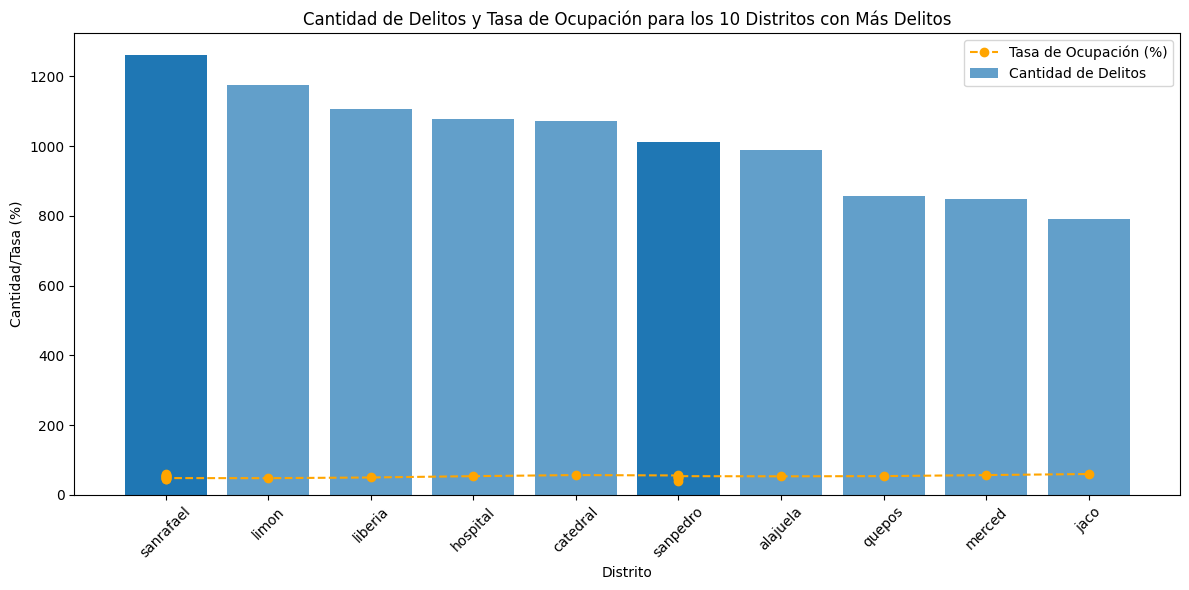

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

# ================================================
# Agrupar por distrito y contar la cantidad de delitos
# ================================================
# Descripción general:
# Este bloque agrupa los datos del OIJ por distrito, cuenta la cantidad de delitos
# y selecciona los 10 distritos con la mayor cantidad de delitos.

top_distritos = df_oij.groupBy("distrito") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10)  # Selecciona los 10 distritos con más delitos

# ================================================
# Convertir a Pandas DataFrame
# ================================================
# Descripción general:
# Convierte el resultado de PySpark a un DataFrame de Pandas para facilitar la manipulación
# y la creación de gráficos.

top_distritos_pd = top_distritos.toPandas()

# ================================================
# Obtener la tasa de ocupación de los distritos correspondientes
# ================================================
# Descripción general:
# Filtra los datos del INEC para los distritos seleccionados y obtiene la tasa de ocupación
# para esos distritos. Luego, convierte el resultado a un DataFrame de Pandas.

tasa_ocupacion = df_inec.filter(
    col("distrito").isin(top_distritos_pd["distrito"].tolist())
).select("distrito", "tasa_de_ocupacion").toPandas()

# ================================================
# Combinar los datos
# ================================================
# Descripción general:
# Combina los datos de delitos y tasa de ocupación en un único DataFrame de Pandas
# utilizando la columna `distrito` como clave.

merged_data = pd.merge(
    top_distritos_pd,
    tasa_ocupacion,
    left_on="distrito",
    right_on="distrito"
)

# ================================================
# Graficar los datos
# ================================================
# Descripción general:
# Crea un gráfico combinado para visualizar la cantidad de delitos y la tasa de ocupación
# en los 10 distritos con más delitos.

plt.figure(figsize=(12, 6))  # Tamaño del gráfico

# Gráfico de barras para la cantidad de delitos
plt.bar(
    merged_data["distrito"],
    merged_data["count"],
    label="Cantidad de Delitos",
    alpha=0.7
)

# Gráfico de líneas para la tasa de ocupación
plt.plot(
    merged_data["distrito"],
    merged_data["tasa_de_ocupacion"],
    label="Tasa de Ocupación (%)",
    color="orange",
    marker="o",
    linestyle="--"
)

# Configuración del título y etiquetas
plt.title("Cantidad de Delitos y Tasa de Ocupación para los 10 Distritos con Más Delitos")
plt.xlabel("Distrito")
plt.ylabel("Cantidad/Tasa (%)")
plt.legend()  # Agregar leyenda
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor visibilidad
plt.tight_layout()  # Ajustar el diseño para evitar solapamiento
plt.show()


### Cantidad de Delitos por Día de la Semana 

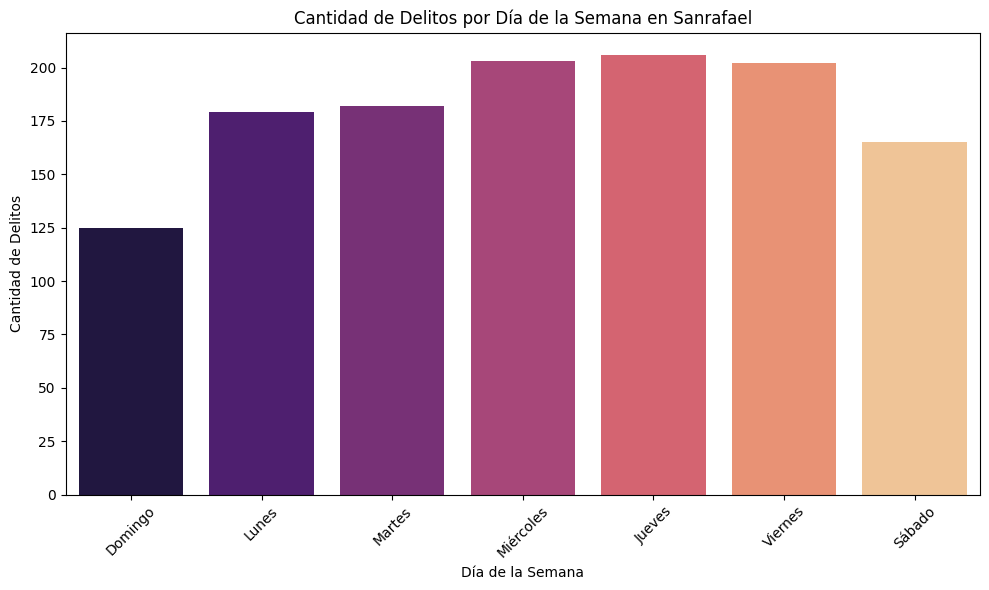

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import dayofweek, to_date, col
import warnings

# ================================================
# Suprimir FutureWarnings de seaborn
# ================================================
# Descripción general:
# Se deshabilitan las advertencias futuras para evitar que interfieran con la visualización del gráfico.
warnings.filterwarnings("ignore", category=FutureWarning)

# ================================================
# Asegurar que la columna 'Fecha' esté en formato de fecha
# ================================================
# Descripción general:
# Convierte la columna `Fecha` en el DataFrame editado del OIJ (`df_oij_editado`)
# al formato de fecha utilizando `to_date`.

df_oij_editado = df_oij_editado.withColumn(
    "Fecha", 
    to_date(col("Fecha"), "M/d/yyyy")  # Define el formato de entrada de la fecha
)

# ================================================
# Encontrar el distrito con más delitos
# ================================================
# Descripción general:
# Agrupa los datos por la columna `Distrito`, cuenta la cantidad de registros,
# y selecciona el distrito con la mayor cantidad de delitos.

distrito_mas_delitos = df_oij_editado.groupBy("Distrito") \
    .count() \
    .orderBy(col("count").desc()) \
    .first()["Distrito"]

# ================================================
# Filtrar datos para el distrito con más delitos
# ================================================
# Descripción general:
# Filtra el DataFrame para incluir únicamente los registros correspondientes
# al distrito con más delitos.

delitos_distrito = df_oij_editado.filter(
    col("Distrito") == distrito_mas_delitos
)

# ================================================
# Extraer el día de la semana
# ================================================
# Descripción general:
# Añade una nueva columna `DiaSemana` que contiene el número del día de la semana
# (1 = Domingo, 7 = Sábado) basado en la columna `Fecha`.

delitos_distrito = delitos_distrito.withColumn(
    "DiaSemana", 
    dayofweek(col("Fecha"))  # Calcula el día de la semana
)

# ================================================
# Mapear los números de día a nombres
# ================================================
# Descripción general:
# Define un diccionario para mapear los números de los días de la semana
# a sus nombres correspondientes.

dias_mapping = {
    1: "Domingo",
    2: "Lunes",
    3: "Martes",
    4: "Miércoles",
    5: "Jueves",
    6: "Viernes",
    7: "Sábado"
}

# Convertir a Pandas DataFrame y mapear los días
delitos_distrito_pd = delitos_distrito.toPandas()
delitos_distrito_pd['DiaSemana'] = delitos_distrito_pd['DiaSemana'].map(dias_mapping)

# ================================================
# Contar delitos por día de la semana
# ================================================
# Descripción general:
# Cuenta el número de delitos por cada día de la semana y asegura
# que los días aparezcan en el orden correcto.

conteo_dias = delitos_distrito_pd['DiaSemana'].value_counts().reindex([
    "Domingo", "Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"
]).fillna(0)

# ================================================
# Gráfico de barras
# ================================================
# Descripción general:
# Crea un gráfico de barras para mostrar la cantidad de delitos por día de la semana
# en el distrito con más delitos.

plt.figure(figsize=(10, 6))  # Tamaño del gráfico
sns.barplot(
    x=conteo_dias.index,  # Eje X: Días de la semana
    y=conteo_dias.values,  # Eje Y: Cantidad de delitos
    palette=sns.color_palette("magma", len(conteo_dias.index))  # Paleta de colores
)

# Configurar título y etiquetas
plt.title(f"Cantidad de Delitos por Día de la Semana en {distrito_mas_delitos.capitalize()}")
plt.xlabel("Día de la Semana")
plt.ylabel("Cantidad de Delitos")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X
plt.tight_layout()  # Ajustar diseño para evitar solapamientos
plt.show()


### Cantidad de Delitos por Tipo en el Distrito

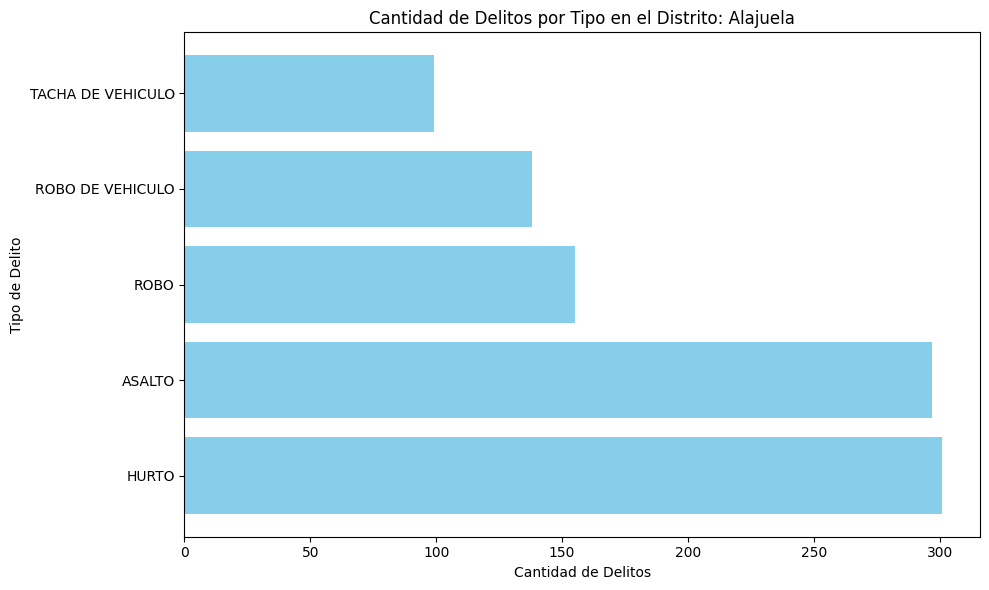

In [35]:
import matplotlib.pyplot as plt

# ================================================
# Seleccionar un distrito
# ================================================
# Descripción general:
# Define el distrito específico que deseas analizar. Puedes cambiar el valor
# de la variable `distrito_seleccionado` para analizar diferentes distritos.

distrito_seleccionado = "alajuela"  # Cambiar al distrito deseado

# ================================================
# Filtrar los datos para el distrito seleccionado
# ================================================
# Descripción general:
# Filtra los registros del DataFrame `df_oij` para incluir únicamente los datos
# del distrito seleccionado. Agrupa los registros por tipo de delito y cuenta la
# cantidad de registros para cada tipo. Finalmente, ordena los resultados en
# orden descendente según el conteo.

delitos_por_tipo_distrito = df_oij.filter(
    col("distrito") == distrito_seleccionado  # Filtrar por distrito
).groupBy(
    "delito"  # Agrupar por tipo de delito
).count().orderBy(
    "count", ascending=False  # Ordenar por cantidad de delitos (descendente)
)

# ================================================
# Convertir a Pandas DataFrame
# ================================================
# Descripción general:
# Convierte el resultado del DataFrame de PySpark a un DataFrame de Pandas para
# facilitar la manipulación y la creación de gráficos.

delitos_por_tipo_distrito_pd = delitos_por_tipo_distrito.toPandas()

# ================================================
# Graficar
# ================================================
# Descripción general:
# Crea un gráfico de barras horizontales para visualizar la cantidad de delitos
# por tipo en el distrito seleccionado.

plt.figure(figsize=(10, 6))  # Establecer el tamaño del gráfico
plt.barh(
    delitos_por_tipo_distrito_pd["delito"],  # Eje Y: Tipos de delitos
    delitos_por_tipo_distrito_pd["count"],  # Eje X: Cantidad de delitos
    color="skyblue"  # Color de las barras
)

# Configuración del título y etiquetas
plt.title(f"Cantidad de Delitos por Tipo en el Distrito: {distrito_seleccionado.title()}")
plt.xlabel("Cantidad de Delitos")
plt.ylabel("Tipo de Delito")
plt.tight_layout()  # Ajustar diseño para evitar solapamiento
plt.show()  # Mostrar el gráfico


### Cantidad de Delitos por Sexo

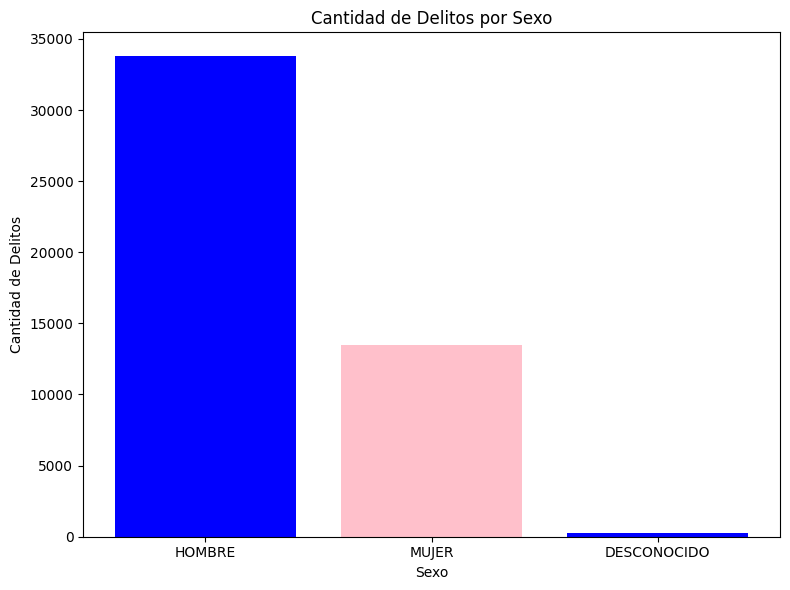

In [36]:
import matplotlib.pyplot as plt

# ================================================
# Agrupar por sexo y contar la cantidad de delitos
# ================================================
# Descripción general:
# Agrupa los datos en el DataFrame `df_oij` por la columna `sexo`, cuenta el
# número de registros por cada categoría, y ordena los resultados en orden
# descendente según la cantidad.

delitos_por_sexo = df_oij.groupBy("sexo") \
    .count() \
    .orderBy("count", ascending=False)  # Ordenar por cantidad de delitos

# ================================================
# Convertir a Pandas DataFrame
# ================================================
# Descripción general:
# Convierte el resultado del DataFrame de PySpark a un DataFrame de Pandas para
# facilitar la manipulación y la creación de gráficos.

delitos_por_sexo_pd = delitos_por_sexo.toPandas()

# ================================================
# Graficar
# ================================================
# Descripción general:
# Crea un gráfico de barras para visualizar la cantidad de delitos por sexo.

plt.figure(figsize=(8, 6))  # Establecer el tamaño del gráfico
plt.bar(
    delitos_por_sexo_pd["sexo"],  # Eje X: Categorías de sexo
    delitos_por_sexo_pd["count"],  # Eje Y: Cantidad de delitos
    color=["blue", "pink"]  # Colores para las barras
)

# Configuración del título y etiquetas
plt.title("Cantidad de Delitos por Sexo")
plt.xlabel("Sexo")
plt.ylabel("Cantidad de Delitos")
plt.xticks(rotation=0)  # Asegurar que las etiquetas del eje X estén horizontalmente alineadas
plt.tight_layout()  # Ajustar diseño para evitar solapamiento
plt.show()  # Mostrar el gráfico


### Propuesta de Visualización

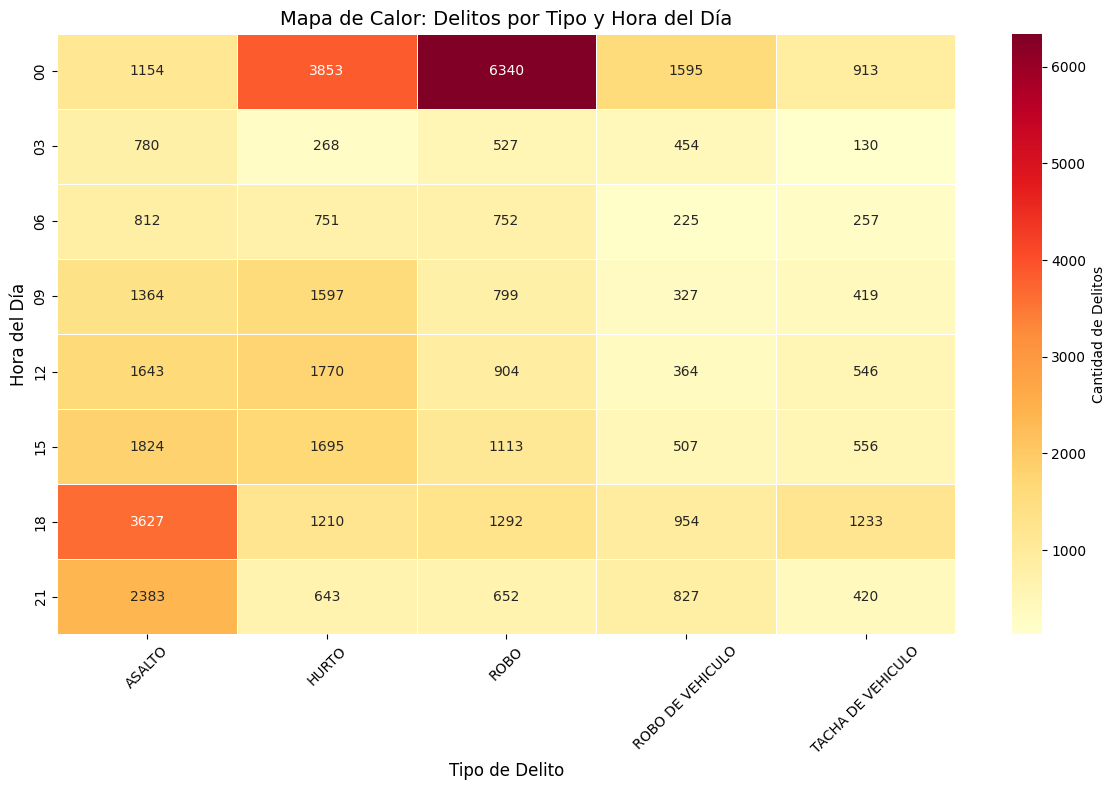

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# ================================================
# Extraer la hora de inicio
# ================================================
# Descripción general:
# Agrega una nueva columna `hora_inicio` al DataFrame `df_oij` que contiene
# únicamente las horas (los dos primeros caracteres) de la columna `hora`.

df_oij_with_hour = df_oij.withColumn(
    "hora_inicio", 
    col("hora").substr(1, 2)  # Extraer los dos primeros caracteres de la columna `hora`
)

# ================================================
# Agrupar los datos por hora del día y tipo de delito
# ================================================
# Descripción general:
# Agrupa los datos del DataFrame por las columnas `hora_inicio` y `delito`,
# contando la cantidad de registros para cada combinación.

delitos_por_hora_y_tipo = df_oij_with_hour.groupBy("hora_inicio", "delito") \
    .count()  # Contar registros en cada grupo

# ================================================
# Convertir a Pandas para graficar
# ================================================
# Descripción general:
# Convierte el resultado del DataFrame de PySpark a un DataFrame de Pandas
# para poder graficarlo utilizando Matplotlib y Seaborn.

delitos_por_hora_y_tipo_pd = delitos_por_hora_y_tipo.toPandas()

# ================================================
# Pivoteo de datos
# ================================================
# Descripción general:
# Reorganiza los datos para que las filas correspondan a las horas (`hora_inicio`),
# las columnas correspondan a los tipos de delitos (`delito`), y los valores
# correspondan a la cantidad de delitos.

heatmap_data = delitos_por_hora_y_tipo_pd.pivot(
    index="hora_inicio",  # Filas: Hora del día
    columns="delito",  # Columnas: Tipos de delitos
    values="count"  # Valores: Cantidad de delitos
).fillna(0)  # Rellenar valores faltantes con 0

# ================================================
# Crear el mapa de calor
# ================================================
# Descripción general:
# Crea un mapa de calor utilizando Seaborn para visualizar la cantidad de delitos
# por tipo y hora del día.

plt.figure(figsize=(12, 8))  # Establecer el tamaño del gráfico
sns.heatmap(
    heatmap_data,  # Datos para el mapa de calor
    cmap="YlOrRd",  # Esquema de colores (amarillo a rojo)
    annot=True,  # Mostrar los valores en las celdas
    fmt=".0f",  # Formato de los valores (números enteros)
    linewidths=0.5,  # Líneas entre celdas
    cbar_kws={'label': 'Cantidad de Delitos'}  # Etiqueta para la barra de colores
)

# Personalización del gráfico
plt.title("Mapa de Calor: Delitos por Tipo y Hora del Día", fontsize=14)  # Título
plt.xlabel("Tipo de Delito", fontsize=12)  # Etiqueta del eje X
plt.ylabel("Hora del Día", fontsize=12)  # Etiqueta del eje Y
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor visibilidad
plt.tight_layout()  # Ajustar diseño para evitar solapamiento

# Mostrar el gráfico
plt.show()
